In [1]:
import pyodbc
import sqlalchemy
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

In [2]:
with open(f'/Users/terrill/Documents/work/stuff/spy_trend/sql_server_info_equities.txt', 'r') as f:
    line = f.readline().split(',')
name, user, password = line[0], line[3], line[4]

sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{name}')
%load_ext sql
%sql mssql+pyodbc://$user:$password@$name
%config SqlMagic.displaycon = False

<h5>Cleaning up Yahoo data</h5>

In [3]:
def clean_yahoo_df(df, ticker):
    df.drop(['HighPrice','LowPrice','OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_Volume', 'ClosePrice': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

In [4]:
main_df = %sql select * from equities.dbo.spy order by date

main_df = clean_yahoo_df(main_df.DataFrame(), 'SPY')
main_df.tail()

Done.


,SPY,SPY_Volume
Date,,
2020-06-26,300.05,127961000
2020-06-29,304.46,79773300
2020-06-30,308.36,113394800
2020-07-01,310.52,72396500
2020-07-02,312.23,69344200


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [5]:
spy_dates = list(main_df.index)

Below are all tickers pulled from Yahoo and saved locally. I will need to find a way to automate the refresh daily but for now will use the data I have to optimize the model.

Also note, for the individual sector ETFs, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [7]:
etfs = ['QQQ', 'IWM', 'TLT', 'IEF', 'VNQ', 'VGT', 'VHT', 'VFH', 'VCR', 'VIS', 'VDC', 'VPU', 'VDE', 'VAW', 'VOX']

futures = ['CL=F', 'GC=F', 'SI=F', 'ZF=F', 'ZN=F']

In [8]:
%%capture

for ticker in etfs:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

for ticker in futures:
    new_ticker = ticker.replace('=','_')
    query = %sql SELECT * FROM Futures.dbo.$new_ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

In [10]:
main_df.tail(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,CL=F,CL=F_Volume,GC=F,GC=F_Volume,SI=F,SI=F_Volume,ZF=F,ZF=F_Volume,ZN=F,ZN=F_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,308.36,113394800,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,...,39.66,143721086.0,1800.4,87426446.0,18.60,27498487.0,125.74,222311932.0,139.16,436197367.0
2020-07-01,310.52,72396500,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,...,39.61,171886332.0,1778.3,128714431.0,18.26,40526778.0,125.60,247177437.0,138.94,524020934.0
2020-07-02,312.23,69344200,252.19,31956500.0,142.40,24022400.0,163.59,7599800.0,121.72,3054100.0,...,40.32,130102415.0,1787.1,89155862.0,18.25,21540289.0,125.73,175910173.0,139.16,405103512.0


<h5>Other charts (Treasure bond yields, Libor rate, Mortgage rate, M1 & M2 money supply, VIX, DIX)</h5>
<br>
Data pulled from various sources.

In [39]:
# maybe include VVIX in the future?
# Notes:
# 30 year fixed mortgage rate is updated monthly (need may numbers)
# money supply data is updated weekly

economics_tickers = ['CPIAUCSL', 'DFF', 'DGS10', 'DGS30', 'M1', 'M2', 'MORTGAGE15US', 'MORTGAGE30US',
                     'T10YIE', 'UNRATE', 'USD1MTD156N', 'USD6MTD156N', 'USD12MD156N']
economic_names = ['CPI', 'Fed_Funds_Rate', '10_yr_Treasury', '30_yr_Treasury', 'M1_Supply',
                  'M2_Supply', '15_yr_Mortgage', '30_yr_Mortgage', '10_yr_Inflation',
                  'Unemployment', '1m_Libor', '3m_Libor', '12m_Libor']

forex = ['USD_JPY', 'USD_EUR', 'USD_CHF', 'USD_PLN', 'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD',
         'USD_RON', 'USD_INR', 'USD_GBP', 'USD_AUD', 'USD_HKD', 'USD_SEK', 'USD_SGD', 'XAU_USD',
         'DXY']

vix = 'I_VIX'
dix = 'DIX'

In [49]:
# %%capture

# economics data
for ticker, name in zip(economics_tickers, economic_names):
    query = %sql SELECT top 10 * FROM Economics.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={temp_df.columns[0]: name}, inplace=True)
    if ticker in ['M1', 'M2']:
        temp_df *= 1000000000
#     main_df = main_df.join(economics_df, how='outer')



Done.


,CPI
Date,
2020-05-01,255.7680
2020-04-01,255.9020
2020-03-01,257.9530
2020-02-01,259.0500
2020-01-01,258.8200
2019-12-01,258.4440
2019-11-01,257.8240
2019-10-01,257.2290
2019-09-01,256.5930


In [37]:
# economic data
for code, name in zip(economics, economic_names):
    try:
        economics_df = pd.read_csv(f'{path}/final_dfs/{economics_path}/{code}.csv')
        economics_df = economics_df.loc[economics_df['DATE'] >= '1993-01-01']
        economics_df.rename(columns={code: name}, inplace=True)
        economics_df.set_index('DATE', inplace=True)
        if code in ['M1_supply', 'M2_supply']:
            economics_df = economics_df * 1000000000
        elif code == 'GFDEBTN':
            economics_df = economics_df * 1000000
        elif code == 'CPIAUCSL':
            economics_df
        else:
            economics_df = economics_df / 100
    except:
#         economics_df.replace('.', np.nan, inplace=True)
#         economics_df.ffill(inplace=True)
#         economics_df = economics_df.astype(float)
#         economics_df = economics_df / 100
        print(code, name)
#     main_df = main_df.join(economics_df, how='outer')

# # currency (check date format)
# currency_df = pd.read_csv(f'{path}/final_dfs/{currency_path}/{currency[0]}.csv')
# currency_df.drop([' Open',' High',' Low'], axis=1, inplace=True)
# currency_df.rename(columns={' Close': currency[0]}, inplace=True)
# currency_df['Date'] = currency_df['Date'].apply(lambda x: dt.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d'))
# currency_df.set_index('Date', inplace=True)
# main_df = main_df.join(currency_df, how='left')

# # forex (source from yahoo but format is a little different)
# for f in forex:
#     forex_df = pd.read_csv(f'{path}/final_dfs/{forex_path}/{f}.csv')    
#     forex_df.drop(['Open','High','Low'], axis=1, inplace=True)
#     forex_df.rename(columns={'Close': f}, inplace=True)
#     forex_df['Date'] = forex_df['Date'].apply(lambda x: dt.strptime(x, '%b %d %Y').strftime('%Y-%m-%d'))
#     forex_df.set_index('Date', inplace=True)
#     main_df = main_df.join(forex_df, how='left')

# # vix
# vix_df = clean_yahoo_df(f'{path}/final_dfs/{vix}.csv')
# vix_df.drop('^vix_volume', axis=1, inplace=True)
# main_df = main_df.join(vix_df, how='left')

# # dix
# dix_df = pd.read_csv(f'{path}/final_dfs/{dix}.csv')
# dix_df.drop('price', axis=1, inplace=True)
# dix_df.set_index('date', inplace=True)
# main_df = main_df.join(dix_df, how='left')

CPIAUCSL CPI
DFF Fed_Funds_Rate
DGS10 10_yr_Treasury
DGS30 30_yr_Treasury
M1 M1_Supply
M2 M2_Supply
MORTGAGE15US 15_yr_Mortgage
MORTGAGE30US 30_yr_Mortgage
T10YIE 10_yr_Inflation
UNRATE Unemployment
USD1MTD156N 1m_Libor
USD6MTD156N 3m_Libor
USD12MD156N 12m_Libor


In [10]:
main_df.tail(3)

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,USD-INR,USD-GBP,USD-AUD,USD-HKD,USD-SEK,USD-SGD,XAU-USD,^vix,dix,gex
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.105,0.8102,1.5623,7.7523,9.8476,1.4209,1685.89,NaN,NaN,NaN
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.794,0.8088,1.5399,7.7509,9.8095,1.4140,1717.94,NaN,NaN,NaN
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.495,0.8178,1.5475,7.7522,9.8043,1.4235,1730.65,NaN,NaN,NaN


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [11]:
main_df.ffill(inplace=True)

In [12]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head()

,spy_volume,spy,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,...,USD-INR,USD-GBP,USD-AUD,USD-HKD,USD-SEK,USD-SGD,XAU-USD,^vix,dix,gex
1993-01-29,1003200.0,26.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.42,NaN,NaN
1993-02-01,480500.0,26.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.33,NaN,NaN
1993-02-02,201300.0,26.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.25,NaN,NaN
1993-02-03,529400.0,26.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.12,NaN,NaN
1993-02-04,531500.0,26.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN


<h5>Last Value Method</h5>
We will be shifiting the target value up by one day, meaning we will set the current adjusted closing price as the previous day's adjusted closing price

In [13]:
main_df['spy_shift_1d'] = main_df['spy'].shift(-1)
main_df.drop(main_df.tail(1).index, inplace=True)
main_df.drop('spy', axis=1, inplace=True)

In [14]:
main_df.tail(3)

,spy_volume,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,vdc_volume,...,USD-GBP,USD-AUD,USD-HKD,USD-SEK,USD-SGD,XAU-USD,^vix,dix,gex,spy_shift_1d
2020-04-28,105270000.0,46862800.0,211.50,47292700.0,129.11,56100.0,111.16,75600.0,173.41,141600.0,...,0.8048,1.5406,7.7502,9.9003,1.4172,1708.64,33.57,0.440944,9.315513e+08,293.21
2020-04-29,118745600.0,48716400.0,219.00,50390500.0,135.46,106800.0,114.60,73400.0,178.42,164800.0,...,0.8020,1.5253,7.7502,9.8462,1.4118,1712.39,31.23,0.445038,2.502561e+09,290.48
2020-04-30,122901700.0,42955500.0,218.91,43727500.0,130.31,87100.0,110.97,73500.0,177.22,267200.0,...,0.7940,1.5359,7.7523,9.7577,1.4110,1685.05,34.15,0.457729,3.331689e+09,282.79


<h5>Getting Rolling Mean and Standard Deviation</h5>
To be used later to inverse scale predictions. We will try using the 5 day rolling mean and std for now and then experiment with other days later.

In [15]:
main_df['spy_mean'] = main_df['spy_shift_1d'].rolling(window=5, min_periods=1).mean()
main_df['spy_std'] = main_df['spy_shift_1d'].rolling(window=5, min_periods=1).std()
main_df.tail()

,spy_volume,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,vdc_volume,...,USD-HKD,USD-SEK,USD-SGD,XAU-USD,^vix,dix,gex,spy_shift_1d,spy_mean,spy_std
2020-04-24,85166000.0,34303400.0,213.84,27155800.0,122.41,37300.0,105.96,59500.0,169.46,118900.0,...,7.7505,10.0579,1.4246,1729.43,35.93,0.439759,1.264911e+09,287.05,280.248,5.203698
2020-04-27,77896600.0,36451700.0,215.56,39021300.0,127.26,83200.0,109.09,200600.0,173.22,451600.0,...,7.7502,10.0183,1.4186,1715.57,33.29,0.432132,1.284878e+09,285.73,282.786,3.681159
2020-04-28,105270000.0,46862800.0,211.50,47292700.0,129.11,56100.0,111.16,75600.0,173.41,141600.0,...,7.7502,9.9003,1.4172,1708.64,33.57,0.440944,9.315513e+08,293.21,285.608,5.231120
2020-04-29,118745600.0,48716400.0,219.00,50390500.0,135.46,106800.0,114.60,73400.0,178.42,164800.0,...,7.7502,9.8462,1.4118,1712.39,31.23,0.445038,2.502561e+09,290.48,287.888,4.018335
2020-04-30,122901700.0,42955500.0,218.91,43727500.0,130.31,87100.0,110.97,73500.0,177.22,267200.0,...,7.7523,9.7577,1.4110,1685.05,34.15,0.457729,3.331689e+09,282.79,287.852,4.073834


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. DIX/GEX data had the most NaN values since it was not recorded until 2011. I could just remove the columns but the main purpose of this project was to see how accurate the DIX index was at predicting SPY prices so I left it in.
<br>
Will do another analysis without DIX/GEX. When that happens we will have data from ~2004

In [16]:
main_df.isna().sum().sort_values(ascending=False).head(5)

gex        4598
dix        4598
USD-HUF    3005
USD-INR    3005
USD-EUR    3005
dtype: int64

In [17]:
main_df = main_df.dropna(axis=0)
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head()

,spy_volume,qqq_volume,qqq,iwm_volume,iwm,vaw_volume,vaw,vcr_volume,vcr,vdc_volume,...,USD-HKD,USD-SEK,USD-SGD,XAU-USD,^vix,dix,gex,spy_shift_1d,spy_mean,spy_std
2011-05-02,126278700.0,48149400.0,53.57,48962400.0,74.88,59000.0,74.33,119000.0,58.26,58000.0,...,7.7663,6.0301,1.2250,1545.00,15.99,0.378842,1.897313e+09,113.14,113.390,0.269537
2011-05-03,138375000.0,38100000.0,53.31,56070000.0,73.94,65800.0,73.38,40400.0,58.00,62700.0,...,7.7656,6.0483,1.2272,1536.83,16.70,0.383411,1.859731e+09,112.39,113.250,0.525024
2011-05-04,182678500.0,53097200.0,53.23,64754600.0,72.98,89000.0,72.09,26000.0,57.78,76000.0,...,7.7706,6.0971,1.2324,1515.95,17.08,0.392122,1.717764e+09,111.37,112.834,0.965883
2011-05-05,226900000.0,72200000.0,52.94,91858900.0,72.65,89400.0,71.42,26300.0,57.68,53500.0,...,7.7720,6.2263,1.2383,1473.65,18.20,0.405457,1.361864e+09,111.86,112.462,0.894913
2011-05-06,222787200.0,72507000.0,53.11,76446200.0,73.03,101100.0,71.95,23800.0,57.80,41300.0,...,7.7714,6.3052,1.2395,1495.25,18.40,0.418649,1.490329e+09,112.30,112.212,0.658308


<h5>Splitting data into train, validation, test sets</h5>

In [18]:
valid_test_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_test_size - valid_test_size

train = main_df.iloc[:train_size].copy()
valid = main_df.iloc[train_size:train_size+valid_test_size].copy()
train_valid = main_df.iloc[:train_size+valid_test_size].copy()
test = main_df.iloc[train_size+valid_test_size:].copy()

<h5>Normalizing Data</h5>

In [19]:
cols_to_normalize = ['spy_volume', 'qqq_volume', 'qqq', 'iwm_volume', 'iwm', 'vaw_volume', 'vaw',
                     'vcr_volume', 'vcr', 'vdc_volume', 'vdc', 'vde_volume', 'vde', 'vfh_volume',
                     'vfh', 'vgt_volume', 'vgt', 'vht_volume', 'vht', 'vis_volume', 'vis', 'vnq_volume',
                     'vnq', 'vox_volume', 'vox', 'vpu_volume', 'vpu', 'cl=f_volume', 'cl=f', 'gc=f_volume',
                     'gc=f', 'ief_volume', 'ief', 'tlt_volume', 'tlt', 'CPI', 'M1_supply', 'M2_supply',
                     'dxy', 'USD-JPY', 'USD-EUR', 'USD-CHF', 'USD-PLN', 'USD-CNY', 'USD-HUF', 'USD-RUB', 
                     'USD-CAD', 'USD-RON', 'USD-INR', 'USD-GBP', 'USD-AUD', 'USD-HKD', 'USD-SEK', 'USD-SGD',
                     'XAU-USD', '^vix', 'gex', 'spy_shift_1d']
# cols_to_normalize = []
# for i in main_df.columns:
#     if main_df[i].iloc[0] >= 1:
#         cols_to_normalize.append(i)
# cols_to_normalize

In [20]:
from sklearn.preprocessing import StandardScaler

# scaling train data
scaler_train = StandardScaler()
train_scaled = scaler_train.fit_transform(train[cols_to_normalize])
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_normalize, index=train.index)
train_scaled = train_scaled.join(train.loc[:, ~train.columns.isin(cols_to_normalize)])
train_scaled.shape

(1359, 75)

In [21]:
#scaling train_valid data

scaler_train_valid = StandardScaler()
train_valid_scaled = scaler_train_valid.fit_transform(train_valid[cols_to_normalize])
train_valid_scaled = pd.DataFrame(train_valid_scaled, columns=cols_to_normalize, index=train_valid.index)
train_valid_scaled = train_valid_scaled.join(train_valid.loc[:, ~train_valid.columns.isin(cols_to_normalize)])
train_valid_scaled.shape

(1812, 75)

In [22]:
# scaling valid data - separating target columns for another scaler object

scaler_valid = StandardScaler()
valid_scaled = scaler_valid.fit_transform(valid[cols_to_normalize].drop('spy_shift_1d', axis=1))
valid_scaled = pd.DataFrame(valid_scaled, columns=cols_to_normalize[:-1], index=valid.index)
valid_scaled = valid_scaled.join(valid.loc[:, ~valid.columns.isin(cols_to_normalize)].drop(['spy_mean','spy_std'],axis=1))
valid_scaled.shape

(453, 72)

In [23]:
# scaling test data - separating target columns for another scaler object

scaler_test = StandardScaler()
test_scaled = scaler_test.fit_transform(test[cols_to_normalize].drop('spy_shift_1d', axis=1))
test_scaled = pd.DataFrame(test_scaled, columns=cols_to_normalize[:-1], index=test.index)
test_scaled = test_scaled.join(test.loc[:, ~test.columns.isin(cols_to_normalize)].drop(['spy_mean','spy_std'],axis=1))
test_scaled.shape

(453, 72)

In [24]:
# creating separate scaler objects for valid and test targets to use in the future to inverse scaled predictions

# scaler_y_valid = StandardScaler()
# y_valid_scaled = scaler_y_valid.fit_transform(np.array(valid['spy_shift_1d']).reshape(-1,1))

# scaler_y_test = MinMaxScaler()
# y_test_scaled = scaler_y_test.fit_transform(np.array(test['spy_shift_1d']).reshape(-1,1))

In [25]:
# scaling formula

# minmaxscalar
# std = (valid['spy_shift_1d'] - valid['spy_shift_1d'].min()) / (valid['spy_shift_1d'].max() - valid['spy_shift_1d'].min())
# reverse = std * (valid['spy_shift_1d'].max() - valid['spy_shift_1d'].min()) + valid['spy_shift_1d'].min()

# standardscalar
# std = (valid['spy_shift_1d'] - valid['spy_shift_1d'].mean()) / valid['spy_shift_1d'].std()
# z = (x - u) / s

<h5>Splitting into X and y</h5>

In [26]:
features = [i for i in main_df.columns if i not in ['spy_shift_1d','spy_mean','spy_std']]
target = 'spy_shift_1d'

In [27]:
# non-scaled data

X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]

y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]


print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (1359, 72)
X_valid shape: (453, 72)
X_train_valid shape: (1812, 72)
X_test shape: (453, 72)

Targets
y_train shape: (1359,)
y_valid shape: (453,)
y_train_valid shape: (1812,)
y_test shape: (453,)


In [28]:
# scaled data

X_train_scaled = train_scaled[features]
X_valid_scaled = valid_scaled[features]
X_train_valid_scaled = train_valid_scaled[features]
X_test_scaled = test_scaled[features]

y_train_scaled = train_scaled[target]
y_train_valid_scaled = train_valid_scaled[target]

print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'X_valid_scaled shape: {X_valid_scaled.shape}')
print(f'X_train_valid_scaled shape: {X_train_valid_scaled.shape}')
print(f'X_test shape_scaled: {X_test_scaled.shape}')

X_train_scaled shape: (1359, 72)
X_valid_scaled shape: (453, 72)
X_train_valid_scaled shape: (1812, 72)
X_test shape_scaled: (453, 72)


<h5>Model using XGBoost</h5>

In [29]:
# default parameter values
n_estimators = 100
max_depth = 3
learning_rate = 0.1
gamma = 0
min_child_weight = 1
subsample = 1
colsample_bytree = 1
colsample_by_level = 1

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

model = XGBRegressor(n_estimators = n_estimators,
                     max_depth = max_depth,
                     learning_rate = learning_rate,
                     gamma = gamma,
                     min_child_weight = min_child_weight,
                     subsample = subsample,
                     colsample_bytree = colsample_bytree,
                     #colsample_by_level=colsample_by_level,
                     random_state = 0)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<h5>Predicting Training Set</h5>

In [31]:
train_predict_scaled = model.predict(X_train_scaled)

# train_max, train_min = inverse_scale(train)
train_predict = train_predict_scaled * train['spy_std'] + train['spy_mean']

print(f'RMSE: {math.sqrt(mean_squared_error(y_train, train_predict))}')

RMSE: 2.0398289995723067


Text(0.5, 1.0, 'Train Predictions')

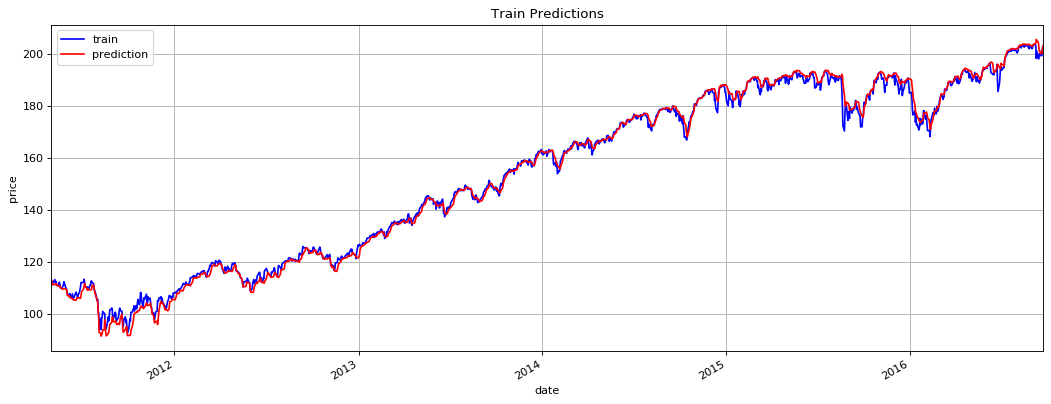

In [32]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

train_predict_df = pd.DataFrame({'predict': train_predict}, index=y_train.index)

ax = y_train.plot(style='b', grid=True)
ax = train_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['train', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Train Predictions')

In [33]:
# predicting validation data

valid_predict_scaled = model.predict(X_valid_scaled)
valid_predict = valid_predict_scaled * valid['spy_std'] + valid['spy_mean']
original_rmse = math.sqrt(mean_squared_error(y_valid, valid_predict))

print(f'RMSE: {original_rmse}')

RMSE: 2.5725501073404473


Not scaling the targets made it so the predictions were within the ranges of the training set. After scaling predictions

Text(0.5, 1.0, 'Valid Predictions')

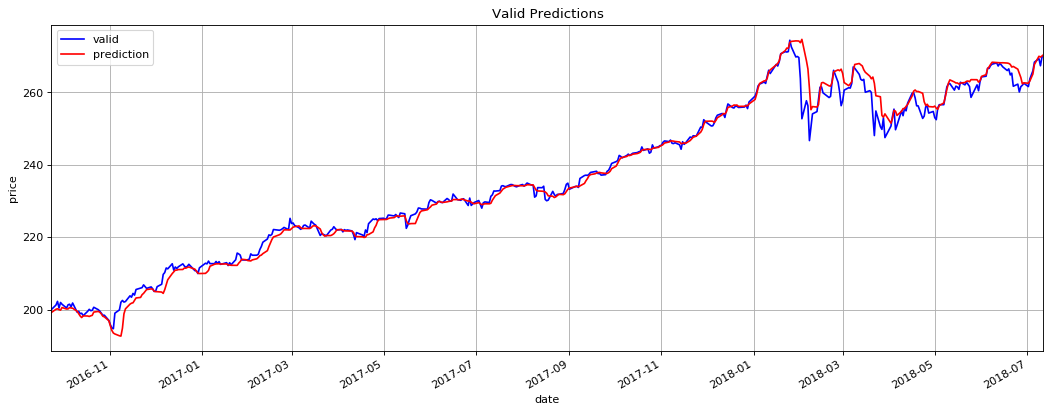

In [34]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

valid_predict_df = pd.DataFrame({'predict': valid_predict}, index=y_valid.index)

ax = y_valid.plot(style='b', grid=True)
ax = valid_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['valid', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Valid Predictions')

In [35]:
# parameters
# n_estimators = 100
# max_depth = 3
# learning_rate = 0.1
# gamma=0
# min_child_weight=1
# subsample=1
# colsample_bytree=1
# colsample_by_level=1

<h5>Parameter Adjustments</h5>

In [36]:
# function to run model
def train_xgb_model(X_train,
                    y_train,
                    X_test,
                    y_test,
                    mean = valid['spy_mean'],
                    std = valid['spy_std'],
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    learning_rate = learning_rate,
                    gamma = gamma,
                    min_child_weight = min_child_weight,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    #colsample_by_level=colsample_by_level,
                    random_state=0):
    
    xgb = XGBRegressor(n_estimators=n_estimators,
                       max_depth=max_depth,
                       learning_rate=learning_rate,
                       gamma=gamma,
                       min_child_weight=min_child_weight,
                       subsample=subsample,
                       colsample_bytree=colsample_bytree,
                       #colsample_by_level=colsample_by_level,
                       random_state=0)

    xgb.fit(X_train, y_train)
    train_predict_scaled = xgb.predict(X_test)

    train_predict = train_predict_scaled * std + mean

    return math.sqrt(mean_squared_error(y_test, train_predict)), train_predict

<h5>max_depth & min_child_weight</h5>
- parameters to control complexitity of trees
- tune together to find trade off between bias and variance

<b>max_depth</b> - maximum number of nodes allowed from the root to the farthest leaf of a tree; deeper trees lead to overfitting<br>
<b>min_child_weight</b> - minimum weight required to create a new node; smaller weights creates child leafs with fewer samples that can lead to overfitting

default values:
max_depth = 3,
min_child_weight = 1

In [37]:
max_depth_range = range(1,11)
min_child_weight_range = range(1,16)

error_rate = {'max_depth':[], 'min_child_weight':[], 'rmse':[]}

for param in max_depth_range:
    for param2 in min_child_weight_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    max_depth = param,
                                    min_child_weight = param2)

        error_rate['max_depth'].append(param)
        error_rate['min_child_weight'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,max_depth,min_child_weight,rmse
0,1,1,2.56228
1,1,2,2.56228
2,1,3,2.56228
3,1,4,2.56228
4,1,5,2.56228


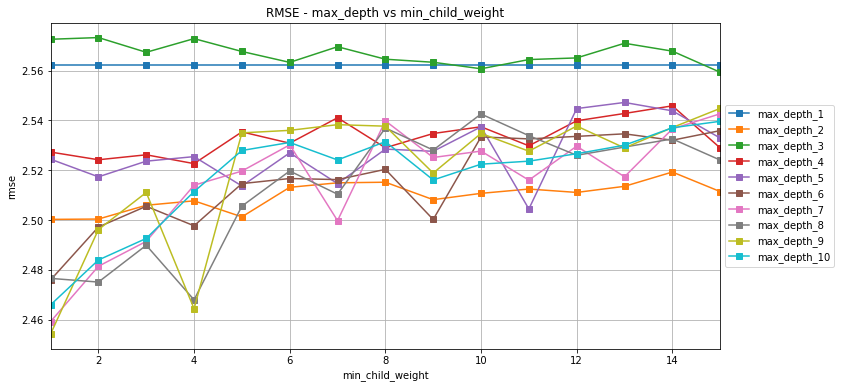

In [38]:
rcParams['figure.figsize'] = 12, 6
#plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

legend_list = ['max_depth_1']

ax = error_rate_df[error_rate_df['max_depth'] == 1].plot(x='min_child_weight', y='rmse', marker='s', grid=True)

for i in max_depth_range[1:]:
    temp = error_rate_df[error_rate_df['max_depth'] == i]
    ax = temp.plot(x='min_child_weight', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'max_depth_{i}')

ax.set_xlabel('min_child_weight')
ax.set_ylabel('rmse')
ax.set_title('RMSE - max_depth vs min_child_weight')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [39]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_max_depth = temp['max_depth'].iloc[0]
new_min_child_weight = temp['min_child_weight'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal max_depth: {new_max_depth}')
print(f'Optimal min_child_weight: {new_min_child_weight}')

Minimum RMSE: 2.4542651581757076
Optimal max_depth: 9
Optimal min_child_weight: 1


<h5>subsample & colsample_bytree</h5>
- parameters to control sampling of dataset done at each boosting round

<b>subsample</b> - subsample of observations; 1 means to use all rows<br>
<b>colsample_bytree</b> - subsample of featuers; 1 means to use all columns

default values: subsample = 1, colsample_bytree = 1

In [40]:
subsample_range = [i/10 for i in range(1,11)]
colsample_bytree_range = [i/10 for i in range(1,11)]

error_rate = {'subsample':[], 'colsample_bytree':[], 'rmse':[]}

for param in subsample_range:
    for param2 in colsample_bytree_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    subsample = param,
                                    colsample_bytree = param2,
                                    max_depth = new_max_depth,
                                    min_child_weight = new_min_child_weight)

        error_rate['subsample'].append(param)
        error_rate['colsample_bytree'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,subsample,colsample_bytree,rmse
0,0.1,0.1,1.965881
1,0.1,0.2,2.189741
2,0.1,0.3,2.312584
3,0.1,0.4,2.286325
4,0.1,0.5,2.280114


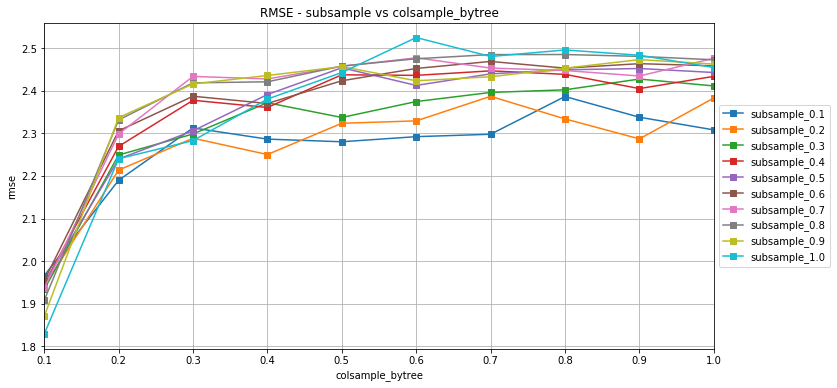

In [41]:
rcParams['figure.figsize'] = 12, 6
#plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

legend_list = ['subsample_0.1']

ax = error_rate_df[error_rate_df['subsample'] == 0.1].plot(x='colsample_bytree', y='rmse', marker='s', grid=True)

for i in subsample_range[1:]:
    temp = error_rate_df[error_rate_df['subsample'] == i]
    ax = temp.plot(x='colsample_bytree', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'subsample_{i}')

ax.set_xlabel('colsample_bytree')
ax.set_ylabel('rmse')
ax.set_title('RMSE - subsample vs colsample_bytree')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [42]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_subsample = temp['subsample'].iloc[0]
new_colsample_bytree = temp['colsample_bytree'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal subsample: {new_subsample}')
print(f'Optimal colsamble_bytree: {new_colsample_bytree}')

Minimum RMSE: 1.8289403340080115
Optimal subsample: 1.0
Optimal colsamble_bytree: 0.1


<h5>colsample_by_level</h5>
- tuning the last parameter (before gamma) individually<br>
- not doing this for now

<b>colsample_bylevel</b> - subsample ratio of columns for each level

default values: colsample_bylevel = 1

In [43]:
# colsample_bylevel_range = [fill in a range]

# error_rate = {'colsample_bylevel':[], 'rmse':[]}

# for param in colsample_bylevel_range:
#     result = train_xgb_model(X_train_scaled,
#                              y_train_scaled,
#                              X_valid_scaled,
#                              y_valid,
#                              max_depth=new_max_depth,
#                              min_child_weight=new_min_child_weight,
#                              subsample=new_subsample,
#                              colsample_bytree=new_colsample_by_tree,
#                              colsample_bylevel=param)

#     error_rate['colsample_bylevel'].append(param)
#     error_rate['rmse'].append(result)

# error_rate_df = pd.DataFrame(error_rate)
# error_rate_df.head()

<h5>gamma</h5>
- tuning gamma individually, tuning it last before (n_estimators & learning_rate) because it depends on other parameters<br>
- might retune other parameters later

<b>gamma</b> - minimum loss reduction required to make a split on leaf node; higher means more regularization (less overfitting... i think)

default values: gamma = 0

In [44]:
gamma_range = [i/10 for i in range(1,11)]

error_rate = {'gamma':[], 'rmse':[]}

for param in gamma_range:
    result, _ = train_xgb_model(X_train_scaled,
                                y_train_scaled,
                                X_valid_scaled,
                                y_valid,
                                max_depth = new_max_depth,
                                min_child_weight = new_min_child_weight,
                                subsample = new_subsample,
                                colsample_bytree = new_colsample_bytree,
                                #colsample_bylevel = new_colsample_bylevel
                                gamma = param)

    error_rate['gamma'].append(param)
    error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,gamma,rmse
0,0.1,1.834374
1,0.2,1.825350
2,0.3,1.827470
3,0.4,1.823044
4,0.5,1.827144


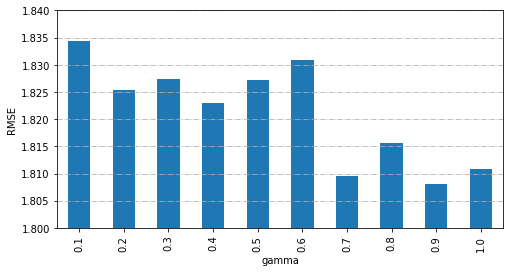

In [45]:
rcParams['figure.figsize'] = 8, 4

ax = error_rate_df.plot.bar(x='gamma', y='rmse')
ax.set_ylim(1.8, 1.84, auto=True)
ax.yaxis.grid(linestyle='-.')
ax.get_legend().remove()
ax.set_ylabel('RMSE')
plt.gcf().set_facecolor('white')

In [46]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_gamma = temp['gamma'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal gamma: {new_gamma}')

Minimum RMSE: 1.8079890067348825
Optimal gamma: 0.9


<h5>learning_rate & n_estimators</h5>
- parameters to control sampling of dataset done at each boosting round

<b>learning_rate</b> - amount to correct for each iteration<br>
<b>n_estimators</b> - number of gradient boosted trees

default values: learning_rate = 0.1, n_estimators = 100

In [47]:
learning_rate_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators_range = range(10, 510, 10)

error_rate = {'learning_rate':[], 'n_estimators':[], 'rmse':[]}

for param in learning_rate_range:
    for param2 in n_estimators_range:
        result, _ = train_xgb_model(X_train_scaled,
                                    y_train_scaled,
                                    X_valid_scaled,
                                    y_valid,
                                    max_depth = new_max_depth,
                                    min_child_weight = new_min_child_weight,
                                    subsample = new_subsample,
                                    colsample_bytree = new_colsample_bytree,
                                    #colsample_bylevel=new_colsample_bylevel
                                    gamma = new_gamma,
                                    learning_rate = param,
                                    n_estimators = param2)

        error_rate['learning_rate'].append(param)
        error_rate['n_estimators'].append(param2)
        error_rate['rmse'].append(result)

error_rate_df = pd.DataFrame(error_rate)
error_rate_df.head()

,learning_rate,n_estimators,rmse
0,0.001,10,1.878640
1,0.001,20,1.877306
2,0.001,30,1.879398
3,0.001,40,1.880661
4,0.001,50,1.879224


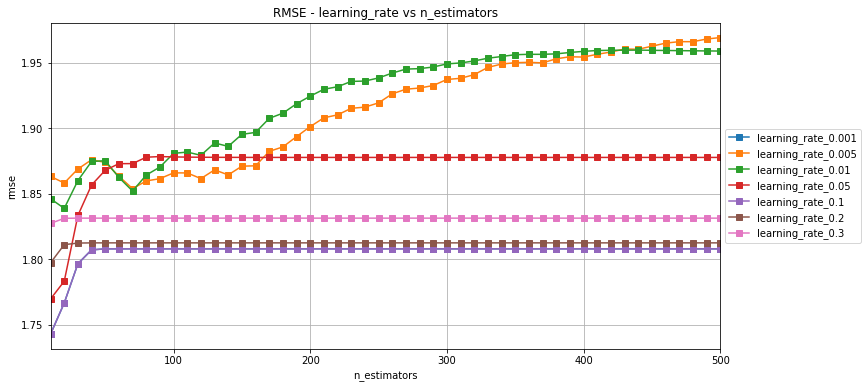

In [48]:
rcParams['figure.figsize'] = 12, 6

legend_list = ['learning_rate_0.001']

ax = error_rate_df[error_rate_df['learning_rate'] == 0.1].plot(x='n_estimators', y='rmse', marker='s', grid=True)

for i in learning_rate_range[1:]:
    temp = error_rate_df[error_rate_df['learning_rate'] == i]
    ax = temp.plot(x='n_estimators', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(f'learning_rate_{i}')

ax.set_xlabel('n_estimators')
ax.set_ylabel('rmse')
ax.set_title('RMSE - learning_rate vs n_estimators')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

In [49]:
temp = error_rate_df[error_rate_df['rmse'] == error_rate_df['rmse'].min()]
min_rmse = temp['rmse'].iloc[0]
new_learning_rate = temp['learning_rate'].iloc[0]
new_n_estimators = temp['n_estimators'].iloc[0]

print(f'Minimum RMSE: {min_rmse}')
print(f'Optimal learning_rate: {new_learning_rate}')
print(f'Optimal n_estimators: {new_n_estimators}')

Minimum RMSE: 1.742880239170608
Optimal learning_rate: 0.1
Optimal n_estimators: 10


<h5>Optimal Parameters</h5>

In [50]:
tuned_params_df = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'gamma',
                             'min_child_weight', 'subsample', 'colsample_bytree', 'rmse'],
                   'original': [n_estimators, max_depth, learning_rate, gamma,
                                min_child_weight, subsample, colsample_bytree, original_rmse],
                   'after_tuning': [new_n_estimators, new_max_depth, new_learning_rate, new_gamma,
                                    new_min_child_weight, new_subsample, new_colsample_bytree, min_rmse]}
tuned_params_df = pd.DataFrame(tuned_params_df)
tuned_params_df

,param,original,after_tuning
0,n_estimators,100.00000,10.00000
1,max_depth,3.00000,9.00000
2,learning_rate,0.10000,0.10000
3,gamma,0.00000,0.90000
4,min_child_weight,1.00000,1.00000
5,subsample,1.00000,1.00000
6,colsample_bytree,1.00000,0.10000
7,rmse,2.57255,1.74288


In [51]:
final_rmse, final_predict = train_xgb_model(X_train = X_train_valid_scaled,
                                            y_train = y_train_valid_scaled,
                                            X_test = X_test_scaled,
                                            y_test = y_test,
                                            mean = test['spy_mean'],
                                            std = test['spy_std'],
                                            n_estimators = new_n_estimators,
                                            max_depth = new_max_depth,
                                            learning_rate = new_learning_rate,
                                            gamma = new_gamma,
                                            min_child_weight = new_min_child_weight,
                                            subsample = new_subsample,
                                            colsample_bytree = new_colsample_bytree,
                                            random_state = 0)

print("RMSE on test set = %0.3f" % final_rmse)

RMSE on test set = 4.562


Text(0.5, 1.0, 'Test Predictions')

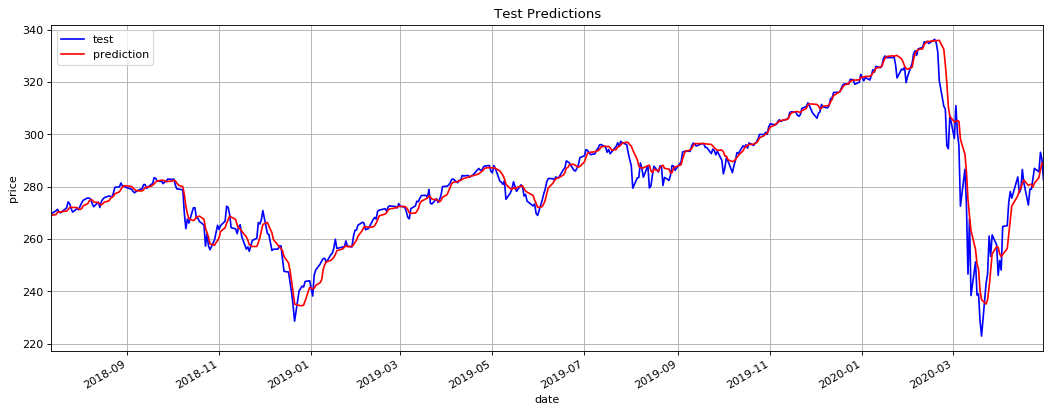

In [52]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

test_predict_df = pd.DataFrame({'predict': final_predict}, index=y_test.index)

ax = y_test.plot(style='b', grid=True)
ax = test_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['test', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Test Predictions')

The results for the final test sets were disappointing, with an RSME of 4.56 compared to the 1.74 of the validation set. Looking at the chart above we can see that there is a slight lag in predictions, especially in turns in direction of the market.

I am curious to see what happens if I exclude data after January 31st which was when the 2020 Covid crash started.

In [53]:
X_test_temp = X_test.loc[:'2020-02-01']
y_test_temp = y_test.loc[:'2020-02-01']

temp_rmse, temp_predict = train_xgb_model(X_train = X_train_valid_scaled,
                                            y_train = y_train_valid_scaled,
                                            X_test = X_test_temp,
                                            y_test = y_test_temp,
                                            mean = test.loc[:'2020-02-01']['spy_mean'],
                                            std = test.loc[:'2020-02-01']['spy_std'],
                                            n_estimators = new_n_estimators,
                                            max_depth = new_max_depth,
                                            learning_rate = new_learning_rate,
                                            gamma = new_gamma,
                                            min_child_weight = new_min_child_weight,
                                            subsample = new_subsample,
                                            colsample_bytree = new_colsample_bytree,
                                            random_state = 0)

print("RMSE on test set = %0.3f" % temp_rmse)

RMSE on test set = 4.012


Text(0.5, 1.0, 'Test Predictions')

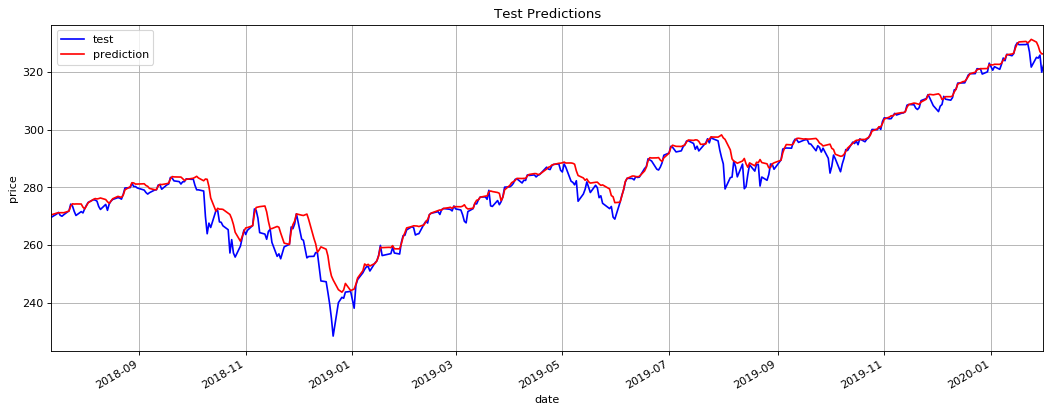

In [54]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

temp_predict_df = pd.DataFrame({'predict': temp_predict}, index=y_test.loc[:'2020-02-01'].index)

ax = y_test.loc[:'2020-02-01'].plot(style='b', grid=True)
ax = temp_predict_df.plot(style='r', grid=True, ax=ax)

ax.legend(['test', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Test Predictions')

Even with the removal of all data after January 31st, we see an improvement from 4.56 to 4.01 RMSE. Although significant this is still a poor score. Lag in the turn of direction of the market persists in all our datasets which will need to be addressed.

The next steps to improving this model:
- feature engineering (add industry ticker data and volume)
- experiment with other parameters like lambda/alpha (regularization) or colsample_bylevel
- stop running model after a few iterations of no improvements for model efficiency
- explore other scaling methods

To do list:
- update to include all of May and June data
- explore adding options data if possible
- find a way to predict trend data (trend line for week/month out)
- try other prediction models
- try tensorflow 

Notes:
- CPI needs April data
- MI & M2 missing last week of April data

6.60152598993426


<Figure size 1280x960 with 0 Axes>

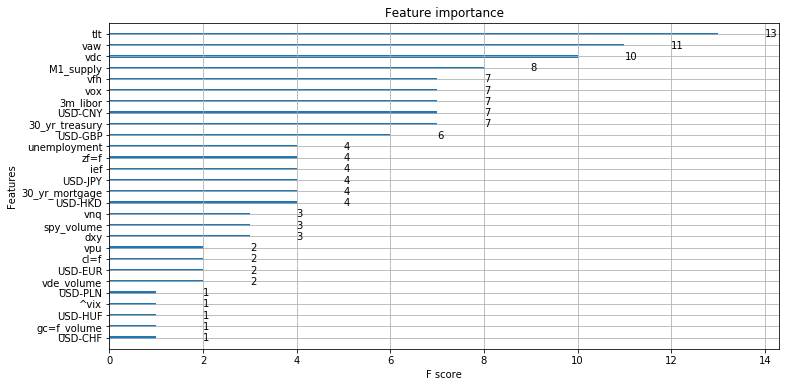

<Figure size 1280x960 with 0 Axes>

In [63]:
import xgboost as xgb

xgb_clf = XGBRegressor(n_estimators=new_n_estimators,
                   max_depth=new_max_depth,
                   learning_rate=new_learning_rate,
                   gamma=new_gamma,
                   min_child_weight=new_min_child_weight,
                   subsample=new_subsample,
                   colsample_bytree=new_colsample_bytree,
                   #colsample_by_level=colsample_by_level,
                   random_state=0)

xgb_clf.fit(X_train_valid_scaled, y_train_valid_scaled)
prediction_scaled = xgb_clf.predict(X_test)

train_predict = prediction_scaled * test['spy_std'] + test['spy_mean']

print(math.sqrt(mean_squared_error(y_test, train_predict)))
# train_predict

xgb.plot_importance(xgb_clf)
plt.figure(figsize=(16, 12), dpi=80, facecolor='w')
# plt.legend(['test', 'prediction'])
# ax.set_xlabel('date')
# ax.set_ylabel('price')
# ax.set_title('Test Predictions')